# 题目

本笔记包含力扣题目 [1515.服务中心的最佳位置](https://leetcode.cn/problems/best-position-for-a-service-centre/) 的求解动画演示代码。

相关链接：[algviz github 开源项目 欢迎Star](https://github.com/zjl9959/algviz)，[algviz 官网](https://algviz.com)。

# 思路

该问题是运筹学里面[中心选址问题](https://zhuanlan.zhihu.com/p/124914964)的简化版本。注意读题可以发现，题目中输入的“客户”坐标是整数，但要求输出的服务中心坐标可以是小数，并且说`与真实值误差在 10-5之内的答案将被视作正确答案`。为什么要特别添加前面的说明呢？因为这是一道竞赛题，要求参赛者在一个半小时内给出答案，所以这里的说明看似是扩大了搜索空间，实际上是为了降低问题的难度。因为解的类型是小数，所以解空间的边界是连续的，可以进一步猜测这里的问题应该都是[凸优化问题](https://www.zhihu.com/question/334515180)，我们可以尝试使用[局部搜索](https://zhuanlan.zhihu.com/p/387380011)的方法来寻找最优解。

我们首先随机找一个位置作为初始解，有了初始解以后，带入公式 $\sum_{i=0}^{n-1}\sqrt{(x_{center}-x_{i})^{2} + (y_{center} - y_{i})^{2}}$ 求出当前解的目标值（即服务中心到所有客户的欧几里得距离）。之后是使用梯度下降的方法来搜索最优解，具体的梯度该如何设置呢？别忘了前面的距离公式！我们只需要求距离公式对 $x_{center}$ 和 $y_{center}$ 的偏导数即可。为了简单起见，这里选择 $(\delta * x_{center}^{'}, \delta * y_{center}^{'})$，其中的 $\delta$ 是我们提前设置好的常量，用来控制算法的收敛速度和误差（$\delta$ 越大收敛越快，同时误差也越大）。

In [1]:
import algviz, math

Max_iter = 100
Threshold = 0.00001

class Solution:
  def getMinDistSum(self, positions):
    # 使用 algviz 对地图进行可视化。
    self.positions = positions
    self.viz = algviz.Visualizer(layout=True)
    self.min_x = min(positions, key=lambda x:x[0])[0]
    self.max_x = max(positions, key=lambda x:x[0])[0]
    self.min_y = min(positions, key=lambda y:y[1])[1]
    self.max_y = max(positions, key=lambda y:y[1])[1]
    self.table = self.viz.createTable(self.max_y + 1, self.max_x + 1, cell_size=(10, 10))
    self.objs = self.viz.createVector(cell_size=(5, 100), histogram=True)
    self.logger = self.viz.createLogger(1, show_line_num=False)
    for pos in positions:
      self.table.mark(algviz.color_light_blue, pos[1], pos[0], True)
    self.viz.display()
    # 选择地图中心点作为服务中心的初始位置。
    self.center_x = (self.min_x + self.max_x) * 0.5
    self.center_y = (self.min_y + self.max_y) * 0.5
    self.obj = self.getDistance(self.center_x, self.center_y)
    self.step = 1
    self.displayCenter()
    self.viz.display()
    # 进行局部搜索。
    self.iter = 0
    while not self.canStop():
      self.iter += 1
      move = self.getDeltMove()
      if move == None:
        continue
      self.center_x += move[0] * self.step
      self.center_y += move[1] * self.step
      self.displayCenter()
      self.objs.append('{:.5f}'.format(self.obj))
      self.obj = self.getDistance(self.center_x, self.center_y)
      self.logger.write('迭代步数：{}，目标值：{:.5f}'.format(self.iter, self.obj))
      self.viz.display()
    return self.obj

  def getDeltMove(self):
    delt_moves = ((-1, 0), (1, 0), (0, -1), (0, 1))
    # 搜索四个方向的邻域动作
    for move in delt_moves:
      dist = self.getDistance(self.center_x + move[0]*self.step, self.center_y + move[1]*self.step)
      if dist < self.obj:
        return move
    # 减少跳跃步长
    self.step /= 2
    return None

  def getDistance(self, x, y):
    dist = 0
    for pos in self.positions:
      dist += math.sqrt((pos[0] - x) ** 2 + (pos[1] - y) ** 2)
    return dist
  
  def displayCenter(self):
    # 由于显示精度问题，这里只显示中心值所在格点的坐标。
    self.table.removeMark(algviz.color_red)
    self.table.mark(algviz.color_red, round(self.center_x), round(self.center_y), True)

  def canStop(self):
    return self.step < Threshold

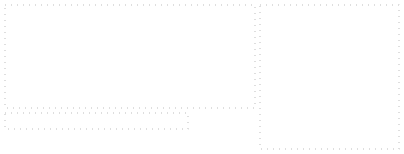

In [8]:
positions = [[0,1],[3,2],[4,5],[7,6],[8,9],[11,1],[2,12]]
solver = Solution()
solver.getMinDistSum(positions)
solver.viz.layout(400)

In [3]:
class SimulatedAnnealingSolution(Solution):
    def getDeltMove(self):
        delt_moves = ((-1, 0), (1, 0), (0, -1), (0, 1))
        # 搜索四个邻居点
        for move in delt_moves:
            dist = self.getDistance(self.center_x + move[0], self.center_y + move[1])
            if dist < self.obj:
                return move
            else:
                pass    # 以一定概率接收较差的解。
        return None
    
    def canStop(self):
        return self.iter > Max_iter

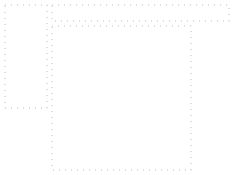

In [7]:
positions = [[0,1],[3,2],[4,5],[7,6],[8,9],[11,1],[2,12]]
solver = SimulatedAnnealingSolution()
solver.getMinDistSum(positions)
solver.viz.layout(300)